<a href="https://colab.research.google.com/github/mohamadhabash/RoBERTa/blob/main/Roberta_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mohammed Habash hacked you!
!pip install transformers
!pip install shutup

     |████████████████████████████████| 2.8 MB 9.4 MB/s 
     |████████████████████████████████| 895 kB 47.2 MB/s 
     |████████████████████████████████| 636 kB 46.0 MB/s 
     |████████████████████████████████| 50 kB 6.0 MB/s 
     |████████████████████████████████| 3.3 MB 47.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import shutup; shutup.please()
import pandas as pd
import numpy as np
import torch

RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
!gdown --id 1c4jKy5AIS-5oISB1ObT5tKZEo2IM8TQF # train.csv
!gdown --id 1Kgr9D5Fmu8AyyG-v2b0gMvNa-rKHhcF3 # test.csv

Downloading...
From: https://drive.google.com/uc?id=1c4jKy5AIS-5oISB1ObT5tKZEo2IM8TQF
To: /content/train.csv
3.50MB [00:00, 13.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Kgr9D5Fmu8AyyG-v2b0gMvNa-rKHhcF3
To: /content/test.csv
100% 314k/314k [00:00<00:00, 2.09MB/s]


# Data preprocessing

In [ ]:
df_train = pd.read_csv('/content/train.csv', index_col=0)
df_test = pd.read_csv('/content/test.csv', index_col=0)

df_train.head()

,text,selected_text,sentiment
textID,,,
cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
088c60f138,my boss is bullying me...,bullying me,negative
9642c003ef,what interview! leave me alone,leave me alone,negative
358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
print(len(df_train))
print(len(df_test))

27481
3534


In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_train, test_size=0.13, random_state=RANDOM_SEED)

In [ ]:
len(df_val)

3573

In [ ]:
def create_label(sentiment):
  if sentiment == 'negative':
    return 0
  elif sentiment == 'neutral':
    return 1
  else: 
    return 2

df_train['score'] = df_train.sentiment.apply(create_label)
df_test['score'] = df_test.sentiment.apply(create_label)
df_val['score'] = df_val.sentiment.apply(create_label)

df_train.head()

,text,selected_text,sentiment,score
textID,,,,
77a1abb2ba,mom just woke me u[p and i am so mad i was dre...,o stupid,negative,0
11a05040a9,you okay bby?,you okay bby?,neutral,1
0a4cc4c868,"had to pause tv, now i`m 10 minutes behind on BGT","had to pause tv, now i`m 10 minutes behind on BGT",neutral,1
c5fbcd3afa,u no there was no point pointing it out yeste...,they were kinda pissed,negative,0
c1608cfd9d,I want an iPhone <33333,I want an iPhone <33333,positive,2


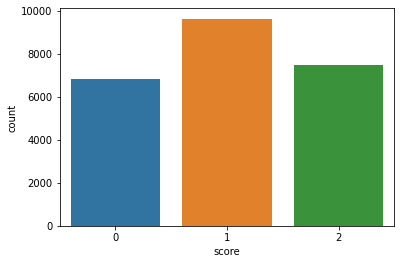

In [ ]:
import seaborn as sns
sns.countplot(df_train.score, x=['negative','neutral','positive'])

In [ ]:
from transformers import RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
sample_txt = 'Hello, How are you? I am under the water, Please help me! sfosd'
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
print('Special Tokens')
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

Special Tokens
</s> 2
<s> 0
<pad> 1
<unk> 3


In [ ]:
print(encoding['input_ids'][0])
print(encoding['attention_mask'][0])

tensor([    0, 31414,     6,  1336,    32,    47,   116,    38,   524,   223,
            5,   514,     6,  3401,   244,   162,   328,   579,   506,   366,
          417,     2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


# Choose maximum sequence length

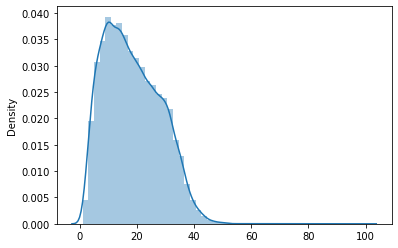

In [ ]:
token_lens = []

def calculate_seq_length(df):
  for txt in df.text:
    tokens = tokenizer.tokenize(str(txt))
    token_lens.append(len(tokens))

calculate_seq_length(df_train)
calculate_seq_length(df_val)
calculate_seq_length(df_test)

sns.distplot(token_lens)

In [ ]:
MAX_LEN=64